<a href="https://colab.research.google.com/github/ishancoderr/3D_modeling/blob/main/Building%20a%20Satellite%20Imagery%20Datacube%20from%20AWS%20STAC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pystac-client
!pip install rioxarray
!pip install rasterio
!pip install xarray
!pip install boto3
!pip install s3fs


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.7/207.7 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 98.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.0/201.0 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 99.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 kB 6.4 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 2.0.1
    Uninstalling wrapt-2.0.1:
      Successfully uninstalled wrapt-2.0.1
  Attempting uninstall: fsspec
    Found existing installation:

In [3]:
!apt-get install -y libgdal-dev
!pip install rasterio[gdal]

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgdal-dev is already the newest version (3.8.4+dfsg-1~jammy0).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


In [6]:
import matplotlib.pyplot as plt
from pystac_client import Client
import rioxarray
import xarray as xr
import numpy as np


In [8]:
bbox = [-122.6, 37.0, -122.0, 37.5]

In [23]:
from pystac_client import Client

stac_url = "https://earth-search.aws.element84.com/v1"
catalog = Client.open(stac_url)
catalog

bbox = [-122.6, 37.0, -122.0, 37.5]

items = catalog.search(
    collections=["sentinel-2-l1c"],  # Correct collection ID
    bbox=bbox,
    datetime="2024-01-01/2024-07-31",
    query={"eo:cloud_cover": {"lt": 40}},
    max_items=5000
).item_collection()

print("Found scenes:", len(items))



Found scenes: 43


In [21]:
item = items[0]
item.id, item.datetime


('S2B_10SEF_20240727_0_L1C',
 datetime.datetime(2024, 7, 27, 19, 4, 26, 216000, tzinfo=tzutc()))

In [29]:
import rioxarray

def load_band(asset):
    url = asset.href.replace("s3://", "/vsicurl/https://sentinel-s2-l1c.s3.amazonaws.com/")
    band = rioxarray.open_rasterio(url, masked=True).squeeze()
    return band


In [30]:
# List all asset keys in the scene
print(list(item.assets.keys()))



['blue', 'cirrus', 'coastal', 'granule_metadata', 'green', 'nir', 'nir08', 'nir09', 'red', 'rededge1', 'rededge2', 'rededge3', 'swir16', 'swir22', 'thumbnail', 'tileinfo_metadata', 'visual']


In [32]:
import rioxarray
import s3fs

fs = s3fs.S3FileSystem(anon=True)

B02 = rioxarray.open_rasterio(fs.open(item.assets["blue"].href), masked=True).squeeze()
B03 = rioxarray.open_rasterio(fs.open(item.assets["green"].href), masked=True).squeeze()
B04 = rioxarray.open_rasterio(fs.open(item.assets["red"].href), masked=True).squeeze()
B08 = rioxarray.open_rasterio(fs.open(item.assets["nir"].href), masked=True).squeeze()


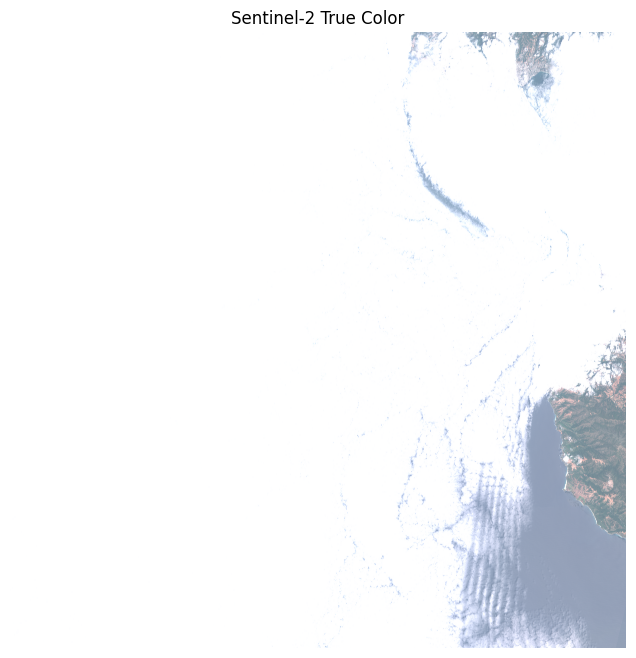

In [33]:
import numpy as np
import matplotlib.pyplot as plt

rgb = np.dstack([B04, B03, B02]) / 3000.0
rgb = np.clip(rgb, 0, 1)

plt.figure(figsize=(8, 8))
plt.imshow(rgb)
plt.title("Sentinel-2 True Color")
plt.axis("off")
plt.show()
